# Data for reproducibility of `Prec6dq10_20M`,`Prec7dq10_20M`

We provide a tutorial on how to load metadata and numerical fits to reproduce our results and/or producing your own fits to the same data used for the `Prec6dq10_20M`,`Prec7dq10_20M` models.

### Notable differences with respect to spin-aligned models:
- We work in a coordinate system whose $z$-axis is aligned with the spin direction of the remnant BH, $\chi_{\rm f}$, a.k.a the ringdown frame. All quantities are expressed in that frame.
- We define time-dependent parameters (like BH spins) at the prograde innermost stable circular orbit (ISCO), which serves as our reference point.
- NR-fitted phases are defined in the interval $[-\pi,\pi]$.

In [1]:
import pandas as pd
import numpy as np
import joblib

## Load metadata

We load metadata from the public SXS catalog of binary black holes (considering only simultaions with IDs SXS:BBH:0001-2265).  
We directly exclude some simulations:
- SXS:BBH:1111 because it does not have "outermost extrapolation" waveform .  
- SXS:BBH:1125 because ringdown portion is very short.

In [2]:
filename = '../postmerger/data/waveform_params/SXS_params_precessing.csv'
df = pd.read_csv(filename)
print(len(df))
df.tail()

2017


,waveform_id,spin_status,theta_f,chifx,chify,chifz,spinf,massf,mass_ratio,delta,...,chi1x_isco,chi1y_isco,chi1z_isco,chi2x_isco,chi2y_isco,chi2z_isco,chi_s_isco,chi_a_isco,kick_velocity,kick_angle
2012,SXS:BBH:2160,spinning_aligned,0.000006,-1.338528e-08,1.751252e-07,0.785484,0.785484,0.958900,3.000070,0.500009,...,6.863128e-08,-3.226067e-08,0.599204,1.680869e-07,-2.657737e-08,-0.399014,0.349654,0.549158,0.000227,1.570741
2013,SXS:BBH:2161,spinning_aligned,0.000061,5.573484e-07,2.401980e-07,0.796406,0.796406,0.957052,3.000142,0.500018,...,2.175978e-07,1.533601e-07,0.599060,2.822620e-09,2.719365e-08,-0.000169,0.449258,0.449342,0.000211,1.569916
2014,SXS:BBH:2162,spinning_aligned,0.000009,-4.890708e-08,7.643711e-09,0.806964,0.806964,0.954930,3.000073,0.500009,...,3.605881e-08,-2.987542e-08,0.599114,-1.128080e-07,2.773371e-08,0.399836,0.549295,0.349381,0.000191,1.570685
2015,SXS:BBH:2163,spinning_aligned,0.000018,2.394728e-08,7.779425e-08,0.811977,0.811977,0.953784,3.000059,0.500007,...,7.263270e-08,1.069805e-07,0.598937,-1.975969e-07,-3.707388e-07,0.599406,0.599054,0.299356,0.000156,1.570451
2016,SXS:BBH:2265,non_spinning,0.000032,5.332686e-08,-7.735071e-08,0.540609,0.540609,0.971102,3.000099,0.500012,...,1.085228e-07,1.368121e-07,-0.000404,-6.852954e-10,7.242479e-11,-0.000004,-0.000304,-0.000302,0.000582,1.570672


The `spin_status` attribute descrbies the binary category depending on the BH spins:

- `non_spinnning`: all spin components are below $10^{-4}$; 
- `spinning_aligned`: all in-plane spin components $(\chi_{1x,y}, \chi_{2x,y})$ are $<10^{-4}$
- `precessing`: at least one in-plane spin component exceeds $10^{-4}$. 


For our analysis we select only quasi-circular binaries:

In [3]:
## select non-eccentric binaries
mask_NE = df['eccentricity']<=1e-3
df2 = df[mask_NE]
df2['eccentricity'].shape

(1886,)

We exclude 17 simulations in which the remnant spin flips to align opposite to the orbital angular momentum, i.e., $\theta_{\rm f} \simeq \pi$. Alongside those, we also exclude the only simulation with $\theta_{\rm f} \simeq \pi/2$

In [4]:
mask_theta = df['theta_f']< 0.8*np.pi
df2 = df[mask_theta]
df2['theta_f'].shape

(2000,)

We exclude seven other simulations due to technical issues, such as differences in their conventions or the presence of numerical artifacts: 
- simulations SXS:BBH:0171, SXS:BBH:1134, and SXS:BBH:0170 have remnant masses larger than the total initial mass; 
- SXS:BBH:1131 has inconsistencies in the reported mass ratio; 
- SXS:BBH:1110 exhibits strong numerical artifacts in the $(2,2)$ mode waveform;

In [5]:
problematic_simulations = ["SXS:BBH:0171", "SXS:BBH:1134", "SXS:BBH:0170",
                           "SXS:BBH:1131", "SXS:BBH:1110",  ]
 
mask_problematic = df['waveform_id'].isin(problematic_simulations)
df2 = df[~mask_problematic]
df2['waveform_id'].shape

(2012,)

Considering all masks:

In [6]:
mask = mask_NE & mask_theta & ~mask_problematic
df2 = df[mask]
df2['waveform_id'].shape

(1866,)

## Load NR fits

Next, we load NR fits for the amplitudes and phases of each waveform. The waveform are ordered through `waveform_id`, similarly to the metadata loaded above.  

Alongside fitted amplitude and phases those, we also provide useful quantities:
- Fit error defined as $$\varepsilon^{\mathrm NR}_{lm} = \frac{\int_{t_0}^{100M}\left| h_{lm}^{\rm NR} - h_{lm}^{\rm fit} \right|^2 dt}{\int_{t_0}^{100M}\left| h_{lm}^{\rm NR} \right|^2 dt}$$
- Timestamps of the peak of $(2,2,0)$ mode, with respect to the start of each simulation.
- Timestamps of the peak of the total waveform norm, $t_{\rm peak\_norm} = \max\limits_{t} \sqrt{\sum_{l,m}\left| h_{l,m} \right|^2}$, with respect to the start of each simulation.
- Timestamps corresponding to $t_{\rm EMOP}$ with respect to the start of each simulation. See the paper for clarifications.
- $\Delta t_{\rm EMOP} = t_{\rm EMOP} - t_{\rm peak\_norm}$


In [2]:
filename = '../postmerger/data/NR_fits/Prec_models_20M_SXS_fits.pkl'
NR_fits = joblib.load(filename)
NR_fits.keys()

dict_keys(['amps', 'phis', 'fit_error', 'time_from_temop', 'waveform_id', 't_peak_220', 't_peak_tot', 't_emop', 'Delta_temop'])

You can access the multipoles $(l,m)$ and the corresponding modes that we fitted for.

In [3]:
LM = {lm:[] for lm in NR_fits['amps'].keys()}
for lm in LM.keys():
    modes_lm = list(NR_fits['amps'][lm].keys())
    LM[lm] = modes_lm
LM

{(2, 2): [(2, 2, 0)],
 (2, -2): [(2, -2, 0)],
 (2, 1): [(2, 1, 0)],
 (2, -1): [(2, -1, 0)],
 (3, 3): [(3, 3, 0)],
 (3, -3): [(3, -3, 0)],
 (2, 0): [(2, 0, 0, 're'), (2, 0, 0, 'im')]}

Loading fits for the amplitudes is as easy as:

In [4]:
lm = (3,3)
mode = (3,3,0)
amp_fits = NR_fits['amps'][lm][mode]
print(amp_fits[:4])
print(amp_fits.shape)

[0.00795396 0.02126257 0.02176561 0.0262633 ]
(2017,)


and similarly for the phases - they are defined in the interval $[-\pi,\pi]$:

In [10]:
lm = (3,3)
mode = (3,3,0)
phi_fits = NR_fits['phis'][lm][mode]
print(phi_fits[:4])
print(phi_fits.shape)

[-2.07192711 -3.13676716  2.98374978 -2.17157264]
(2017,)


## Example plotting amplitude fits vs binary parameters

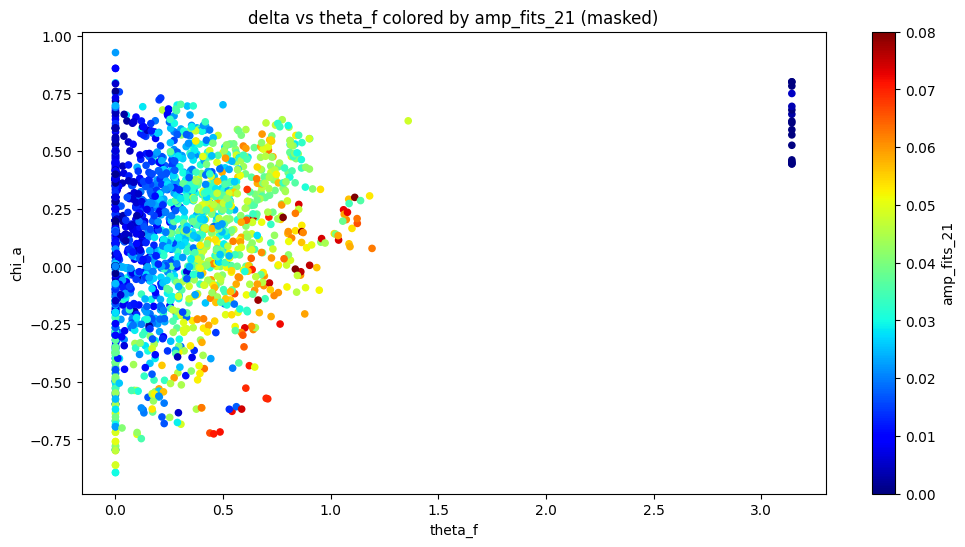

In [ ]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === AMPLITUDE FITS ===

filename = '../postmerger/data/NR_fits/Prec_models_20M_SXS_fits.pkl'
NR_fits = joblib.load(filename)

lm = (2,1)
mode = (2,1,0)
amp_fits_21 = NR_fits['amps'][lm][mode]

names_fits = NR_fits['waveform_id']

# === BINARY PARAMS ===

filename = '../postmerger/data/waveform_params/SXS_params_precessing.csv'
SXS_params_precessing = pd.read_csv(filename)

## Order SXS_params_precessing following names_fits
params = SXS_params_precessing.set_index('waveform_id').loc[names_fits]

# === PLOT ===
plt.figure(figsize=(12,6))
sc = plt.scatter(
    params['theta_f'],
    params['chi_a_isco'],
    c=amp_fits_21,
    cmap='jet',
    vmin=0,
    vmax=0.08,
    s=20
)
plt.colorbar(sc, label='amp_fits_21')
plt.xlabel('theta_f')
plt.ylabel('chi_a')
plt.title('delta vs theta_f colored by amp_fits_21 (masked)')
plt.show()